# Multilayer Perception (Feedforward Network)

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd
import matplotlib.pyplot as plt

/Users/wu/anaconda3/envs/knime/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## DATASET

In [2]:
mnist = input_data.read_data_sets("./Data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./Data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./Data/t10k-images-idx3-ubyte.gz
Extracting ./Data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# start a session
session = tf.Session(graph=tf.get_default_graph())

## Setting

In [4]:
# Hyperparameters
hyperparameters = {}
hyperparameters["learning_rate"] = 0.1
hyperparameters["training_epochs"] = 10
hyperparameters["batch_size"] = 256
hyperparameters["dropout_rate"] = 0.5


# Modelparameters
modelparameters = {}
modelparameters["n_hidden_1"] = 128
modelparameters["n_hidden_2"] = 256
modelparameters["n_input"] = 784
modelparameters["n_output"] = 10
# debug mode, do 1) dimension checking 2) tensor computation graph checking
is_debug = True

parameters_dict = {}
parameters_dict["hyperparameters"] = hyperparameters
parameters_dict["modelparameters"] = modelparameters

## Graph Definition

### Input data

In [5]:
def create_training_data(parameters_dict,is_debug=False):
    """ Training Data
    convention, the last dimension is number of instance
    which differs from tensorflow convention, the first dimension is number of instance
    so a tf.transpose is needed before feeded into tf function
    """
    n_input = parameters_dict["modelparameters"]["n_input"]
    n_output = parameters_dict["modelparameters"]["n_output"]
    
    tf_x = tf.placeholder(tf.float32, [n_input, None], name="features")
    # Adding tensor to default graph
    if is_debug: 
        assert tf_x.graph is tf.get_default_graph()
    tf_y = tf.placeholder(tf.float32, [n_output, None], name="targets")
    
    return tf_x, tf_y

### Network structure

In [6]:
#This is W*X implementation, different from tensorflow layers which is X*W implementation
#parameters = {}
#
#with tf.variable_scope("layer_1", reuse=tf.AUTO_REUSE) as layer_1:
#    parameters["W1"] = tf.get_variable(name="W", shape=(n_hidden_1, n_input), initializer=tf.truncated_normal_initializer(mean=0,stddev=0.1))
#    parameters["b1"] = tf.get_variable(name="b", shape=(n_hidden_1,1), initializer=tf.zeros_initializer())
#
#with tf.variable_scope("layer2", reuse=tf.AUTO_REUSE):
#    parameters["W2"] = tf.get_variable(name="W", shape=(n_hidden_2, n_hidden_1), initializer=tf.truncated_normal_initializer(mean=0,stddev=0.1))
#    parameters["b2"] = tf.get_variable(name="b", shape=(n_hidden_2,1), initializer=tf.zeros_initializer())
#
#with tf.variable_scope("layer3", reuse=tf.AUTO_REUSE):
#    parameters["W3"] = tf.get_variable(name="W", shape=(n_output, n_hidden_2), initializer=tf.truncated_normal_initializer(mean=0,stddev=0.1))
#    parameters["b3"] = tf.get_variable(name="b", shape=(n_output,1), initializer=tf.zeros_initializer())
#    
#
# reuse variable_scope
#with tf.variable_scope(layer_1.original_name_scope):
#    layer_1 = tf.add(tf.matmul(parameters["W1"], tf_x), parameters["b1"])
#    layer_1 = tf.nn.relu(layer_1)
#
#layer_2 = tf.add(tf.matmul(parameters["W2"], layer_1), parameters["b2"])
#layer_2 = tf.nn.relu(layer_2)
# the network
#layer_output = tf.add(tf.matmul(parameters["W3"], layer_2), parameters["b3"])

In [19]:
def create_network(tf_x, parameters_dict, is_debug=False):
    """ Create Neural Network Architecture
    """
    n_hidden_1 = parameters_dict["modelparameters"]["n_hidden_1"]
    n_hidden_2 = parameters_dict["modelparameters"]["n_hidden_2"]
    n_output = parameters_dict["modelparameters"]["n_output"]
    learning_rate = parameters_dict["hyperparameters"]["learning_rate"]
    
    # dropout setting
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    if is_debug:
        assert tf.shape(tf.transpose(tf_x))[-1] is not None
        
    # tensorflow.layers Abstraction
    with tf.variable_scope("layer_1", reuse=tf.AUTO_REUSE) as layer_1:
        layer_1 = tf.layers.dense(tf.transpose(tf_x), n_hidden_1, activation=tf.nn.relu, 
                                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        # Batchnorm
        layer_1 = tf.contrib.layers.batch_norm(layer_1, center=True, scale=True, is_training=is_training)
        layer_1 = tf.layers.dropout(layer_1, rate=learning_rate, training=is_training)

    with tf.variable_scope("layer_2", reuse=tf.AUTO_REUSE) as layer_2:
        layer_2 = tf.layers.dense(layer_1, n_hidden_2, activation=tf.nn.relu,
                                  kernel_initializer=tf.truncated_normal_initializer(stddev=0.1))
        layer_2 = tf.contrib.layers.batch_norm(layer_2, center=True, scale=True, is_training=is_training)
        layer_2 = tf.layers.dropout(layer_2, rate=learning_rate, training=is_training)

    with tf.variable_scope("layer_output", reuse=tf.AUTO_REUSE) as layer_output:
        layer_output = tf.layers.dense(layer_2, n_output, activation=None)
    return layer_output

In [8]:
tf_x, tf_y = create_training_data(parameters_dict)
layer_output = create_network(tf_x, parameters_dict)

### Loss function and optimizer

In [9]:
# tf.nn.softmax_cross_entropy_with_logits requires each row is a probability
with tf.variable_scope("metric") as metric:
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=layer_output, labels= tf.transpose(tf_y))
    cost = tf.reduce_mean(loss, name="cost")

with tf.variable_scope("train") as training:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=parameters_dict["hyperparameters"]["learning_rate"])
    train = optimizer.minimize(cost, name="train")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Prediction

In [10]:
with tf.variable_scope("prediction"):
    correct_prediction = tf.equal(tf.argmax(tf.transpose(tf_y), 1), tf.argmax(layer_output, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

### Check Computation Graph with tensorboard

In [11]:
%%bash
rm -rf ./Data/tmp/graph

In [12]:
writer = tf.summary.FileWriter("./Data/tmp/graph")
writer.add_graph(session.graph)

## Training 

In [13]:
# first eval computation graph
session.run(tf.global_variables_initializer())


epoch_train_acc_list = []
epoch_valid_acc_list = []

training_epochs = parameters_dict["hyperparameters"]["training_epochs"]
batch_size = parameters_dict["hyperparameters"]["batch_size"]
    
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = mnist.train.num_examples // batch_size
        
    # mini Batch
    for i in range(total_batch):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        _, c = session.run(["train/train", "metric/cost:0"], feed_dict={"features:0":batch_x.T, 
                                                                        "targets:0":batch_y.T,
                                                                        "is_training:0": True
                                                                       })
        avg_cost +=c
            
    train_acc = session.run("prediction/accuracy:0", feed_dict={"features:0": mnist.train.images.T, 
                                                                "targets:0":mnist.train.labels.T,
                                                                "is_training:0":False
                                                               })
    valid_acc = session.run("prediction/accuracy:0", feed_dict={"features:0": mnist.validation.images.T, 
                                                                "targets:0":mnist.validation.labels.T,
                                                                "is_training:0":False
                                                               })
        
    print("Epoch: %03d | AvgCost: %.3f" % (epoch + 1, avg_cost / (i + 1)), end="")
    print(" | Train/Valid ACC: %.3f/%.3f" % (train_acc, valid_acc))
    epoch_train_acc_list.append(train_acc)
    epoch_valid_acc_list.append(valid_acc)

Epoch: 001 | AvgCost: 0.362 | Train/Valid ACC: 0.760/0.754
Epoch: 002 | AvgCost: 0.171 | Train/Valid ACC: 0.840/0.839
Epoch: 003 | AvgCost: 0.129 | Train/Valid ACC: 0.828/0.825
Epoch: 004 | AvgCost: 0.105 | Train/Valid ACC: 0.825/0.822
Epoch: 005 | AvgCost: 0.088 | Train/Valid ACC: 0.824/0.823
Epoch: 006 | AvgCost: 0.075 | Train/Valid ACC: 0.802/0.796
Epoch: 007 | AvgCost: 0.065 | Train/Valid ACC: 0.810/0.807
Epoch: 008 | AvgCost: 0.056 | Train/Valid ACC: 0.809/0.811
Epoch: 009 | AvgCost: 0.050 | Train/Valid ACC: 0.811/0.807
Epoch: 010 | AvgCost: 0.044 | Train/Valid ACC: 0.803/0.800


In [14]:
test_acc = session.run("prediction/accuracy:0", feed_dict={"features:0": mnist.test.images.T, 
                                                           "targets:0":mnist.test.labels.T,
                                                           "is_training:0":False
                                                          })
print('Test ACC: %.3f' % test_acc)

Test ACC: 0.802


In [15]:
# end a session
session.close()

## Error Analysis

### Visualize learning curve

In [16]:
df = pd.DataFrame.from_dict({"training_acc":epoch_train_acc_list, "dev_acc":epoch_valid_acc_list})
# translate accuracy to error
df["training_error"] = 1 - df["training_acc"]
df["dev_error"] = 1 - df["dev_acc"]

In [17]:
df.head()

dev_acc  training_acc  training_error  dev_error
0   0.7538      0.759636        0.240364     0.2462
1   0.8392      0.840109        0.159891     0.1608
2   0.8250      0.828055        0.171945     0.1750
3   0.8216      0.824891        0.175109     0.1784
4   0.8226      0.824018        0.175982     0.1774

<Figure size 432x288 with 0 Axes>

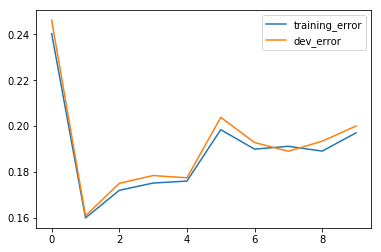

In [18]:
plt.figure()
df[["training_error","dev_error"]].plot()

## Reference

1. https://github.com/rasbt/deep-learning-book/blob/master/code/model_zoo/tensorflow_ipynb/multilayer-perceptron.ipynb
2. tensorboard integration in jupyter notebook https://github.com/lspvic/jupyter_tensorboard